<a href="https://colab.research.google.com/github/RachelRamirez/misclassification_matrix/blob/main/PreExperiment_PA_Shfl_40D_Lambda1_Lambda2_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PreExperiment PA Shfl 40D Lambda1 Lambda2 FineTuning

This notebook is called this because I believe my weights aren't properly responding to the 'new' misclassification cost matrix, after receiving it.  Therefore, I probably need to use fine-tuninign principles to initialize the weights of the neural network, similar to the weights it would have if it was trained with Lambda-1 for 5 epochs, load those with a new initialized network, then send it the updated Lambda-value at 'epoch 5' which is really epoch 1 for the 'new network' and see what happens to the loss values.


## Reduced  capacity neural network with two layers of 40 connections

 

#### Check timezone if incorrect restart

In [6]:
# How to change the local time in Google Colab
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/US/Eastern /etc/localtime
!date

#If this doesn't show the local time correctly, then you need to restart.
import time
time.localtime(time.time())

Sat 22 Apr 2023 04:57:44 PM EDT


time.struct_time(tm_year=2023, tm_mon=4, tm_mday=22, tm_hour=16, tm_min=57, tm_sec=45, tm_wday=5, tm_yday=112, tm_isdst=1)

### Reproducible Seeds

In [7]:
#For Reproducibility
import numpy as np
# np.random.seed(1337)  # for reproducibility

import tensorflow as tf
# tf.random.set_seed(33)

import random as python_random
# python_random.seed(4)

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
seed = 342
tf.keras.utils.set_random_seed(seed) #Possibly use next iteration if the above doesn't work   #This makes everything VERY DETERMINISTIC


# Running more than once causes variation.  try adding this:
# Set seed value
seed_value = 56
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

print("TF version: " , tf.__version__ )
print("Keras version: " , tf.keras.__version__ )


 

TF version:  2.12.0
Keras version:  2.12.0


### Import rest of Library

In [8]:

# from https://github.com/keras-team/keras/issues/2115#issuecomment-204060456
# witha correction on the weighted function in the middle 

'''Train a simple deep NN on the MNIST dataset.
Get to 98.40% test accuracy after 20 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

# from __future__ import print_function  #do i still need this?
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
import keras.backend as K
from itertools import product
import functools
from functools import partial
from time import ctime
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from sklearn.metrics import confusion_matrix
from  sklearn.utils import shuffle

## MORE REPEATABILITY STUFF NEEDED - If theres a way to update this to V2 of Tensorflow great, otherwise I had to use TF 1.0 code
# 5. Configure a new global `tensorflow` session (https://stackoverflow.com/questions/50659482/why-cant-i-get-reproducible-results-in-keras-even-though-i-set-the-random-seeds)
# from keras import backend as K


#I believe thecode below is to help things be repeatable each time different sections in my google colab notebook execute
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [9]:
from google.colab import drive
drive.mount('/content/drive')
!date


Mounted at /content/drive
Sat 22 Apr 2023 04:58:04 PM EDT


In [10]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
# !ls "/content/drive/My Drive/Con3"
path = "/content/drive/MyDrive/Con3/"
 

import pickle 
variable_to_be_deleted = np.array((1,10))
file_name = "delete_later.pkl"
with open(path + file_name, 'wb') as handle:
      
    # A new file will be created
    pickle.dump(variable_to_be_deleted, handle,  protocol=pickle.HIGHEST_PROTOCOL)

print(file_name, " was saved to Google MyDrive ")

import os
try:
    os.remove(path+file_name)
    print(file_name, " was deleted from Google MyDrive ")
except:
    print("Error while deleting file : ", path+file_name)
del(file_name, variable_to_be_deleted)


delete_later.pkl  was saved to Google MyDrive 
delete_later.pkl  was deleted from Google MyDrive 


### Define batch, and format data

In [11]:
batch_size = 256 

# I originally had it very  high batch size to reduce the variation in the data each batch and hope 
# it makes the model training more nearly identical which it did, then i bring it back down to something reasonable to get better results training the NN

nb_classes = 10

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()


X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
# print(X_train.shape[0], 'train samples')
# print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

#Create a Validation Set
X_val = X_test[:7500]   #take the first 7500 for validation
Y_val = Y_test[:7500]   #Take the first 7500 for validation
y_val = y_test[:7500]

X_test = X_test[7500:]  #Keep the last 2500 for test/holdout
Y_test = Y_test[7500:]  #Keep the last 2500 for test/holdout
y_test = y_test[7500:]

print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

#Are the sets relatively balanced? Yes each category is between 8% and 11% per category
print('Train', Y_train.sum(axis=0)/X_train.shape[0])
print('Train # of 9s', Y_train.sum(axis=0)[9])
print('Train # of 4s', Y_train.sum(axis=0)[4])

print('Val', Y_val.sum(axis=0)/X_val.shape[0])
print('Val # of 9s', Y_val.sum(axis=0)[9])
print('Val # of 4s', Y_val.sum(axis=0)[4])

print('Test', Y_test.sum(axis=0)/X_test.shape[0])
print('Test  # of 9s', Y_test.sum(axis=0)[9])
print('Test  # of 4s', Y_test.sum(axis=0)[4])


!date


11490434/11490434 [==============================] - 0s 0us/step
60000 train samples
7500 validation samples
2500 test samples
Train [0.09871667 0.11236667 0.0993     0.10218333 0.09736667 0.09035
 0.09863333 0.10441667 0.09751666 0.09915   ]
Train # of 9s 5949.0
Train # of 4s 5842.0
Val [0.09586667 0.1132     0.10453334 0.10066666 0.09986667 0.09013333
 0.09413333 0.1016     0.09746667 0.10253333]
Val # of 9s 769.0
Val # of 4s 749.0
Test [0.1044 0.1144 0.0992 0.102  0.0932 0.0864 0.1008 0.1064 0.0972 0.096 ]
Test  # of 9s 240.0
Test  # of 4s 233.0
Sat 22 Apr 2023 04:58:10 PM EDT



### Weighted Categorical Cross Entropy Class

In [12]:
#@title
class WeightedCategoricalCrossentropy(tf.keras.losses.CategoricalCrossentropy):

  def __init__(self, cost_mat, name='weighted_categorical_crossentropy', **kwargs):

    cost_mat = np.array(cost_mat)   
    ## when loading from config, self.cost_mat returns as a list, rather than an numpy array. 
    ## Adding the above line fixes this issue, enabling .ndim to call sucessfully. 
    ## However, this is probably not the best implementation
    assert(cost_mat.ndim == 2)
    assert(cost_mat.shape[0] == cost_mat.shape[1])
    super().__init__(name=name, **kwargs)
    self.cost_mat = K.cast_to_floatx(cost_mat)

  def __call__(self, y_true, y_pred, sample_weight=None):
    assert sample_weight is None, "should only be derived from the cost matrix"  
    return super().__call__(
        y_true=y_true, 
        y_pred=y_pred, 
        sample_weight=get_sample_weights(y_true, y_pred, self.cost_mat),
    )


  def get_config(self):
    config = super().get_config().copy()
    # Calling .update on the line above, during assignment, causes an error with config becoming None-type.
    config.update({'cost_mat': (self.cost_mat)})
    return config

  @classmethod
  def from_config(cls, config):
    # something goes wrong here and changes self.cost_mat to a list variable.
    # See above for temporary fix
    return cls(**config)

def get_sample_weights(y_true, y_pred, cost_m):
    num_classes = len(cost_m)

    y_pred.shape.assert_has_rank(2)
    assert(y_pred.shape[1] == num_classes)
    y_pred.shape.assert_is_compatible_with(y_true.shape)

    y_pred = K.one_hot(K.argmax(y_pred), num_classes)

    y_true_nk1 = K.expand_dims(y_true, 2)
    y_pred_n1k = K.expand_dims(y_pred, 1)
    cost_m_1kk = K.expand_dims(cost_m, 0)

    sample_weights_nkk = cost_m_1kk * y_true_nk1 * y_pred_n1k
    sample_weights_n = K.sum(sample_weights_nkk, axis=[1, 2])

    return sample_weights_n


# Register the loss in the Keras namespace to enable loading of the custom object.
tf.keras.losses.WeightedCategoricalCrossentropy = WeightedCategoricalCrossentropy
 

### Plot Model History

In [13]:
def plot_model_history(model_history, nb_epoch, cm3): 
  # Parameters
  # ----------
  # model_history : keras.callbacks.History
  #     The history object returned by the fit() method of the model.
  # cm3 : 10x10 dataframe 
  #      10x10 dataframe of confusion matrix from predicted X_val categories
  # nb_epoch = restored_weights : int
  #     The epoch at which the weights were restored.
  # tot_epochs : int
  #     Calculated Total number of epochs for which the model was trained.
  
   
  tot_epochs = max(model_history.epoch)+1  #if the total epochs ran is 28, it'll show up as 27 in the epoch object so we must add 1
  print("Total Epochs: ", tot_epochs)

  #if tot_epochs is the total number of epochs ran then early stop did not happen, and we need not minus patience
  if tot_epochs == nb_epoch:
    restored_weights = tot_epochs
  else:
    restored_weights  = tot_epochs-patience   #when using restore-best-weights and patience, it'll restore the best weights back
  print("Restored weights at ", restored_weights, "Patience used: ", patience)

  fig = plt.figure(figsize=(20, 10)) # I don't think this works for some reason
  fig, ax = plt.subplots(1,3)
  ax[0].plot(range(1,tot_epochs+1), model_history.history['categorical_accuracy'], color='blue',             label='Training')
  ax[0].plot(range(1,tot_epochs+1), model_history.history['val_categorical_accuracy'] , color='orange',             label='Validation')
  ax[0].scatter((restored_weights), model_history.history['val_categorical_accuracy'][restored_weights-1] , color='orange')
  ax[0].scatter(restored_weights, model_history.history['categorical_accuracy'][restored_weights-1], color='blue')
  ax[0].annotate(text=str(restored_weights),  xy=(restored_weights, model_history.history['val_categorical_accuracy'][restored_weights-1]),
                  textcoords="offset points", xytext=(0,10), ha='center', color='black')
  ax[0].legend()
  ax[0].set_title('Training and Validation Accuracy')

  ax[1].plot(range(1,tot_epochs+1), model_history.history['loss'], color= 'blue', label='Training')
  ax[1].plot(range(1,tot_epochs+1), model_history.history['val_loss'], color='orange', label='Validation')
  ax[1].scatter(restored_weights, model_history.history['loss'][restored_weights-1], color='blue')
  ax[1].scatter((restored_weights), model_history.history['val_loss'][restored_weights-1] , color='orange')
  ax[1].annotate(text=str(restored_weights),  xy=(restored_weights, model_history.history['val_loss'][restored_weights-1]),
                  textcoords="offset points", xytext=(0,10), ha='center')
  ax[1].legend()
  ax[1].set_title('Training and Validation Loss')


  cm3_wodiag = cm3*(np.ones((10,10)) - np.eye(10))

  ax[2] = sns.heatmap(cm3_wodiag, annot=True, annot_kws={"size": 7},  fmt='g', cmap=sns.cm.rocket_r) # font size
  ax[2].set_xlabel('Predicted Class')
  ax[2].set_ylabel('True Class')
  ax[2].set_title('# of misclassifications of 9 as 4 is '+str(cm3[4][9]))
  cbar = ax[2].collections[0].colorbar
  cbar.remove() # Just takes up valuable room and is worthless


  plt.gcf().set_size_inches(15, 5)  # this works 
  # plt.gcf().suptitle(f"Lambda Value {lambda_val} for {nb_epoch} Epochs and Patience {patience} " )

### Train Model with WeightedCategoricalCross Entropy Function 

In [14]:
def create_model(): #Removed cost-matrix which is called up in the Compile Function and passed to the weighted-loss function
  model = Sequential()
  model.add(Dense(40, input_shape=(784,), kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(40, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(10,kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
  model.add(Activation('softmax'))
  return model  #I removed Compile



In [15]:
def log_confusion_matrix( epoch, logs):
  # Use the model to predict the values from the validation dataset.
  y_prediction = model.predict(X_val, verbose=0)     #I call it y_prediction3 because I just want to make sure this is  updated within and not interfering with the other prediction below
  y_prediction  = np.argmax(y_prediction, axis=1)

  #Create confusion matrix 
  cm = confusion_matrix(y_val, y_prediction)
  cm_array = np.asarray(cm)  #Indiv CM as array for storing
  logs['9T_4P'] = cm[9,4]
  logs['4T_9P'] = cm[4,9]
  logs['cm_per_epoch'] = cm_array.reshape((1,100))


In [16]:
def return_cm(model):
  y_prediction = model.predict(X_val, verbose=0)
  y_prediction  = np.argmax(y_prediction, axis=1)
  # Y_prediction = np_utils.to_categorical(y_prediction, nb_classes)

  cm3 = confusion_matrix(y_val, y_prediction)
  cm3 = pd.DataFrame(cm3, range(10),range(10))
  return cm3

  # # plt.figure(figsize = (4,4))
  # # cm3
  # sns.heatmap(cm3, annot=True, annot_kws={"size": 7},  fmt='g') # font size
  # plt.show()
  # # cm_using_weighted_new = cm3
 

In [18]:
# #As of 4/18 I am changing this code to save weights initially after five epochs using lambdavalue=1 initially

# rms = RMSprop()  #https://keras.io/api/optimizers/rmsprop/

# patience = 0
# lambda_val =1
# nb_epoch = 5


# cost_matrix = np.ones((10,10))
# Truth=9
# Predicted=4
# cost_matrix[Truth, Predicted] = lambda_val


# # Define the per-epoch callback.
# cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix, )
# es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights = True)


# model = create_model()

# # save the model weights
# model.save_weights('initial_0epochs.h5')

# model_history = model.fit(X_train, Y_train,  batch_size=batch_size, epochs=5, verbose=2,
#         validation_data=(X_val, Y_val), shuffle=True, use_multiprocessing=True, callbacks = [es_callback, cm_callback])

# # save the model weights
# model.save_weights('initial_5epochs.h5')

# # load the model weights
# model.load_weights('initial_5epochs.h5')

# # print("Parameter values specified for this training-cycle.  Number of epochs: ", nb_epoch, "Number of epochs of Patience: ", patience)

# # print("The cost of a true ", str(Truth), "  predicted as a ", str(Predicted), " is ", lambda_val  )

  
# # ---------------------------------------------------------------------------------------------------------------------------------
# # Training complete.  Make Predictions + Confusion Matrix
# # ---------------------------------------------------------------------------------------------------------------------------------

# #Predict
# cm3 = return_cm(model)

 
# # ---------------------------------------------------------------------------------------------------------------------------------
# # Plot Training History with Accuracy and Loss and CM
# # ---------------------------------------------------------------------------------------------------------------------------------
# #This function takes in three parameters: tot_epochs, model_history, and restored_weights. It plots two graphs, one for categorical accuracy and one for loss. The graphs plot the training and validation values for the model, and also plot and annotate the value of restored_weights. Finally, it displays the plot.

# plot_model_history(model_history, nb_epoch, cm3)



RuntimeError: ignored

In [19]:
def plot_model_history_all(model_history, nb_epoch=None, cm3=None): 
  # Parameters
  # ----------
  # tot_epochs : int
  #     Total number of epochs for which the model was trained.
  # model_history : keras.callbacks.History
  #     The history object returned by the fit() method of the model.
  # cm3 : 10x10 dataframe 
  #      10x10 dataframe of confusion matrix from predicted X_val categories
  # restored_weights : int
  #     The epoch at which the weights were restored.

  

  tot_epochs = max(model_history.epoch)+1  #if the total epochs ran is 28, it'll show up as 27 in the epoch object so we must add 1
  # print("Total Epochs: ", tot_epochs)

  #if tot_epochs is the total number of epochs ran then early stop did not happen, and we need not minus patience
  if tot_epochs == nb_epoch:
    restored_weights = tot_epochs
  else:
    restored_weights  = tot_epochs-patience   #when using restore-best-weights and patience, it'll restore the best weights back
  # print("Restored weights at ", restored_weights, "Patience used: ", patience)

  ax[0].plot(range(1,tot_epochs+1), model_history.history['categorical_accuracy'], color='blue',           )
  ax[0].plot(range(1,tot_epochs+1), model_history.history['val_categorical_accuracy'] , color='orange',    )
  ax[0].scatter((restored_weights), model_history.history['val_categorical_accuracy'][restored_weights-1] , color='orange')
  ax[0].scatter(restored_weights, model_history.history['categorical_accuracy'][restored_weights-1], color='blue')
  ax[0].annotate(text=str(restored_weights),  xy=(restored_weights, model_history.history['val_categorical_accuracy'][restored_weights-1]),
                  textcoords="offset points", xytext=(0,10), ha='center', color='black')
  # ax[0].legend()
  ax[0].set_title('Training (Blue) and Validation (Orange) Accuracy', fontsize='8')

  ax[1].plot(range(1,tot_epochs+1), model_history.history['loss'], color= 'blue',  )
  ax[1].plot(range(1,tot_epochs+1), model_history.history['val_loss'], color='orange',  )
  ax[1].scatter(restored_weights, model_history.history['loss'][restored_weights-1], color='blue')
  ax[1].scatter((restored_weights), model_history.history['val_loss'][restored_weights-1] , color='orange')
  ax[1].annotate(text=str(restored_weights),  xy=(restored_weights, model_history.history['val_loss'][restored_weights-1]),
                  textcoords="offset points", xytext=(0,10), ha='center')
  # ax[1].legend()
  ax[1].set_title('Training (Blue) and Validation (Orange) Loss' , fontsize='8')


  plt.gcf().set_size_inches(10, 5)  # this works 
  # plt.gcf().suptitle(f"Lambda Value {lambda_val} for {nb_epoch} Epochs and Patience {patience} " )

The code below to generate variations of the model training / validation results after training with a cost matrix 30 times did not produce any variability.   Therefore I want to shuffle the training/validation deck randomly between training sessions to see if that helps introduce some randomness.  

Epoch 1/50
235/235 [==============================] - 7s 18ms/step - loss: 0.7539 - categorical_accuracy: 0.7672 - val_loss: 0.3301 - val_categorical_accuracy: 0.9012 - 9T_4P: 36.0000 - 4T_9P: 33.0000 - cm_per_epoch: 75.0000
Epoch 2/50
235/235 [==============================] - 3s 11ms/step - loss: 0.3824 - categorical_accuracy: 0.8886 - val_loss: 0.2535 - val_categorical_accuracy: 0.9260 - 9T_4P: 26.0000 - 4T_9P: 26.0000 - cm_per_epoch: 75.0000
Epoch 3/50
235/235 [==============================] - 4s 18ms/step - loss: 0.3138 - categorical_accuracy: 0.9078 - val_loss: 0.2159 - val_categorical_accuracy: 0.9328 - 9T_4P: 29.0000 - 4T_9P: 19.0000 - cm_per_epoch: 75.0000
Epoch 4/50
235/235 [==============================] - 2s 7ms/step - loss: 0.2764 - categorical_accuracy: 0.9183 - val_loss: 0.1956 - val_categorical_accuracy: 0.9419 - 9T_4P: 21.0000 - 4T_9P: 17.0000 - cm_per_epoch: 75.0000
Epoch 5/50
235/235 [==============================] - 4s 16ms/step - loss: 0.2518 - categorical_accur

<Figure size 2000x1000 with 0 Axes>

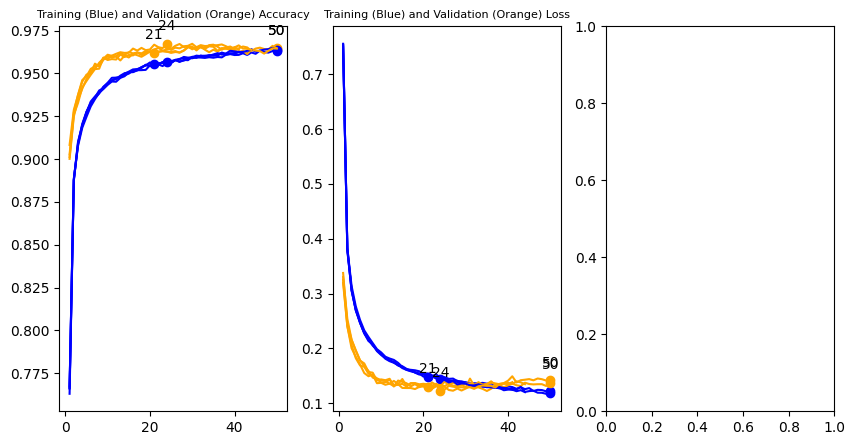

<Figure size 2000x1000 with 0 Axes>

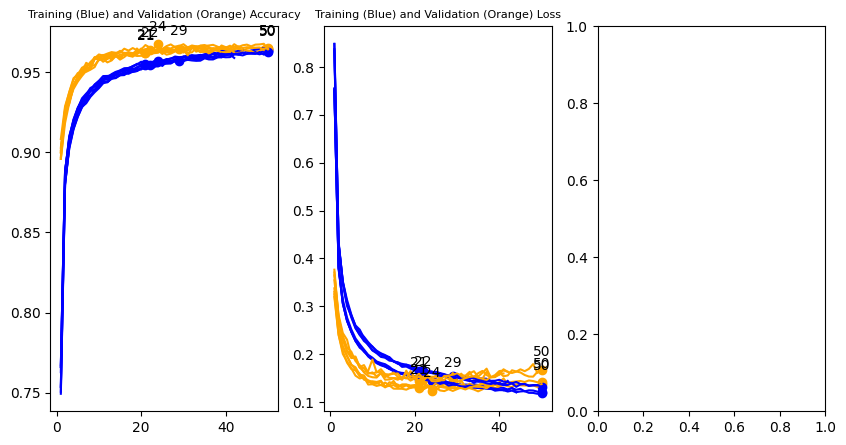

<Figure size 2000x1000 with 0 Axes>

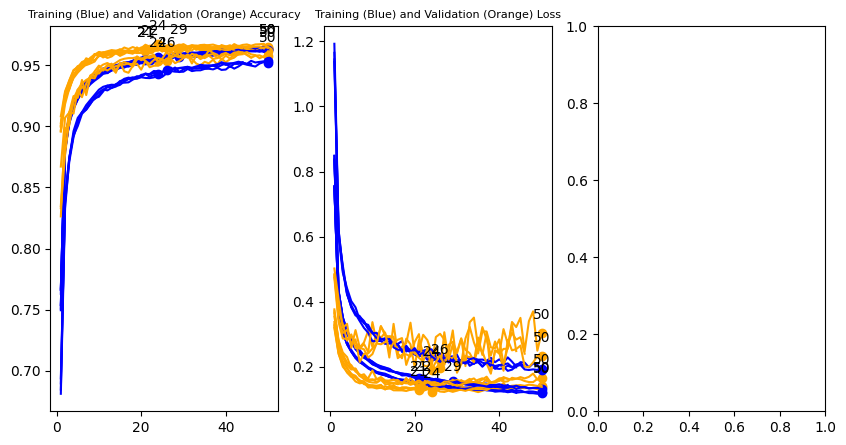

<Figure size 2000x1000 with 0 Axes>

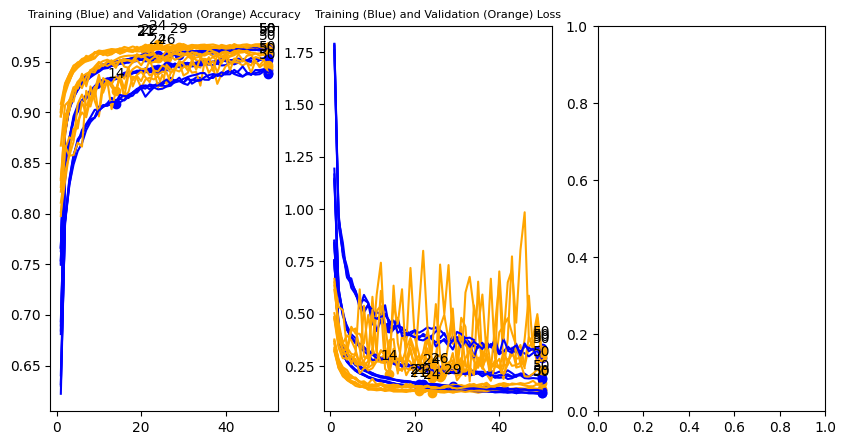

<Figure size 2000x1000 with 0 Axes>

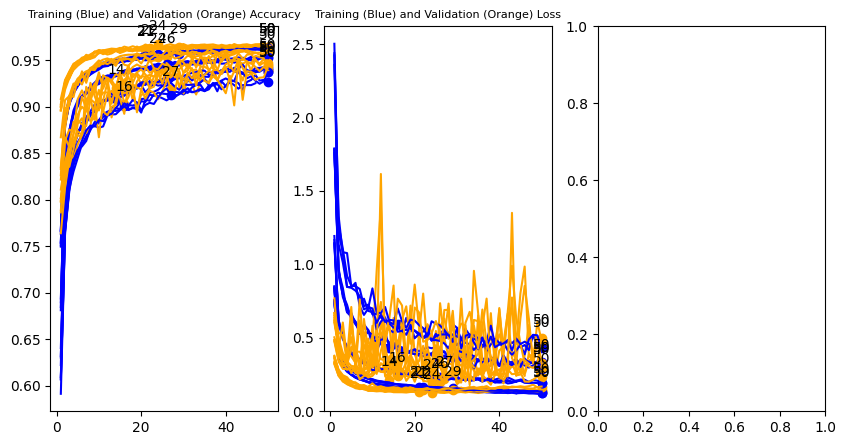

In [22]:

## -----------------------------------------------------------------------------------------------------
## Now we need to load the weights of the model, and continue training with a different cost matrix
## ------------------------------------------------------------------------------------------------------
# load the model weights
# model.load_weights('initial_5epochs.h5')

cost_matrix = np.ones((10,10))

model_history_all = []
cm_all            = []

cost_list = [1, 10, 100, 500, 1000] # Each one takes about 2 minutes 5*4*2=40 minutes for 5 costs/4 reps

for k in cost_list:
  for i in range(4):


    cost_matrix[9,4] = k
    model = create_model()
    # model.load_weights('initial_5epochs.h5')

    model.compile(loss=WeightedCategoricalCrossentropy(cost_matrix), optimizer=rms,  metrics='categorical_accuracy',)
    # model.load_weights('initial_5epochs.h5')
    
    nb_epoch = 50
    patience = 20

    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights = True)

    X_train_shuffled = shuffle(X_train, random_state=42+i)
    Y_train_shuffled = shuffle(Y_train, random_state=42+i)


    history = model.fit(X_train_shuffled, Y_train_shuffled,          batch_size=batch_size, epochs=nb_epoch, verbose=1,
            validation_data=(X_val, Y_val), shuffle=True, use_multiprocessing=True, callbacks = [es_callback, cm_callback])

    cm3 = return_cm(model)

    model_history_all.append(history)
    cm_all.append(cm3)
    ## Now I need to plot all of the "model_history_all"
  
  # print(model_history_all)
  fig = plt.figure(figsize=(20, 10)) # I don't think this works for some reason
  fig, ax = plt.subplots(1,3)
  for item, cm in zip(model_history_all,cm_all):
      # print(item)
    plot_model_history_all(item, nb_epoch, cm)



  # print(model_history_all) #18 items into _ is taking 1 hours and 3 minutes!  perhaps im not usng the right settings - i have no-accelerator on google colab

<Figure size 2000x1000 with 0 Axes>

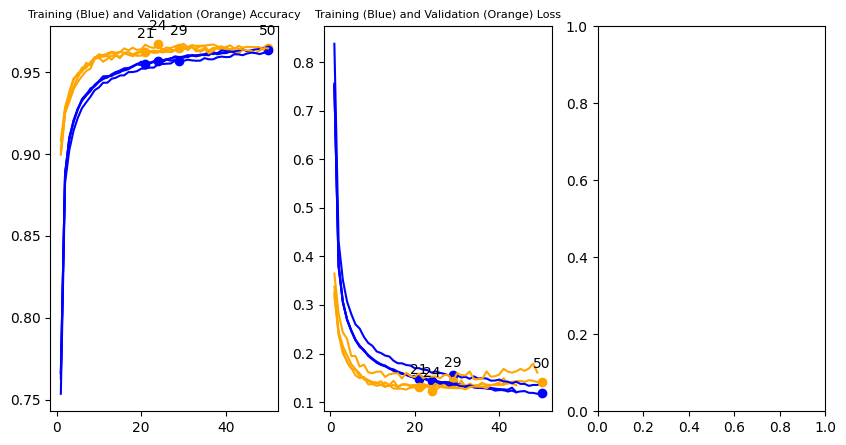

<Figure size 2000x1000 with 0 Axes>

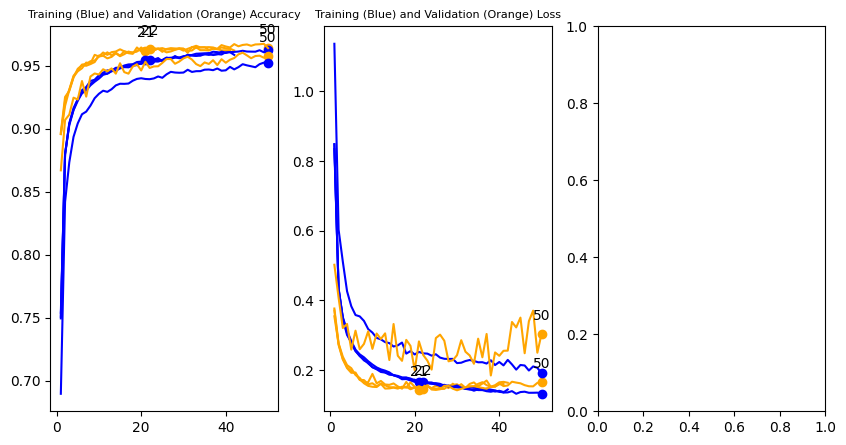

<Figure size 2000x1000 with 0 Axes>

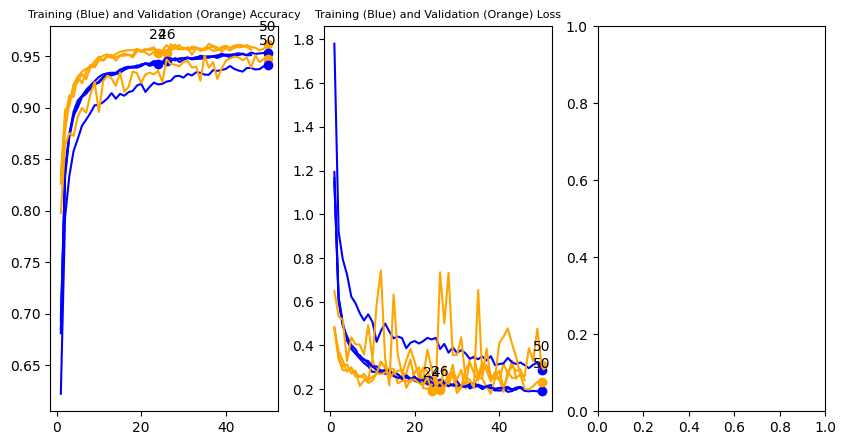

<Figure size 2000x1000 with 0 Axes>

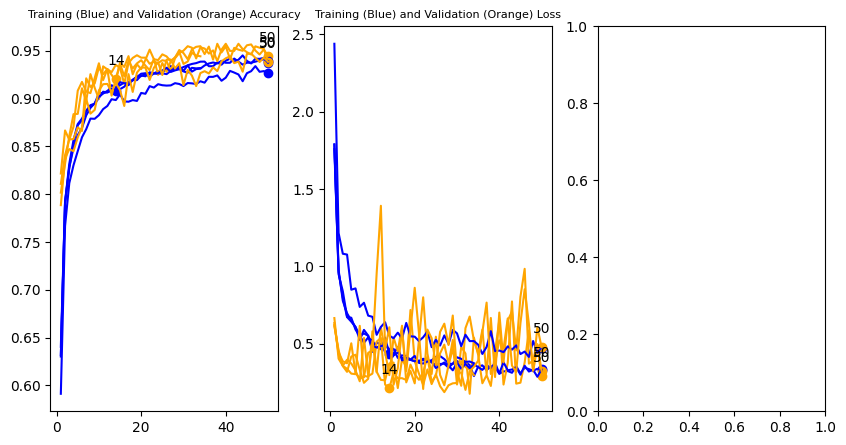

<Figure size 2000x1000 with 0 Axes>

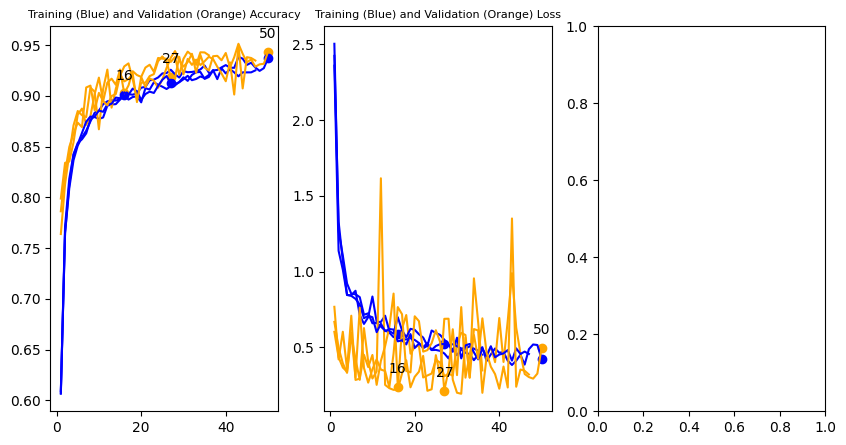

In [42]:



for r in range(0,20,4):
  # print(r)
  ## Now I need to plot all of the "model_history_all"
  fig = plt.figure(figsize=(20, 10)) # I don't think this works for some reason
  fig, ax = plt.subplots(1,3)

  for item, cm in zip(model_history_all[0+r+1:r+4+1], cm_all):
      # print(item)
    plot_model_history_all(item, nb_epoch, cm)
    # print(0+r,' to ', r+4+1)  #Correct


In [ ]:
print(model_history_all)


[<keras.callbacks.History object at 0x7fefd45c6c40>, <keras.callbacks.History object at 0x7fefd4476a90>, <keras.callbacks.History object at 0x7fefd41d1a90>, <keras.callbacks.History object at 0x7fefbd46d400>, <keras.callbacks.History object at 0x7fefc2aa9790>, <keras.callbacks.History object at 0x7fefc29bd130>, <keras.callbacks.History object at 0x7fefc2740190>, <keras.callbacks.History object at 0x7fefc256be20>, <keras.callbacks.History object at 0x7fefdc262940>, <keras.callbacks.History object at 0x7fefc26009d0>]


Total Epochs:  5
Restored weights at  3 Patience used:  2


Text(0.5, 0.98, 'Lambda Value 1 for 10 Epochs and Patience 2 ')

<Figure size 2000x1000 with 0 Axes>

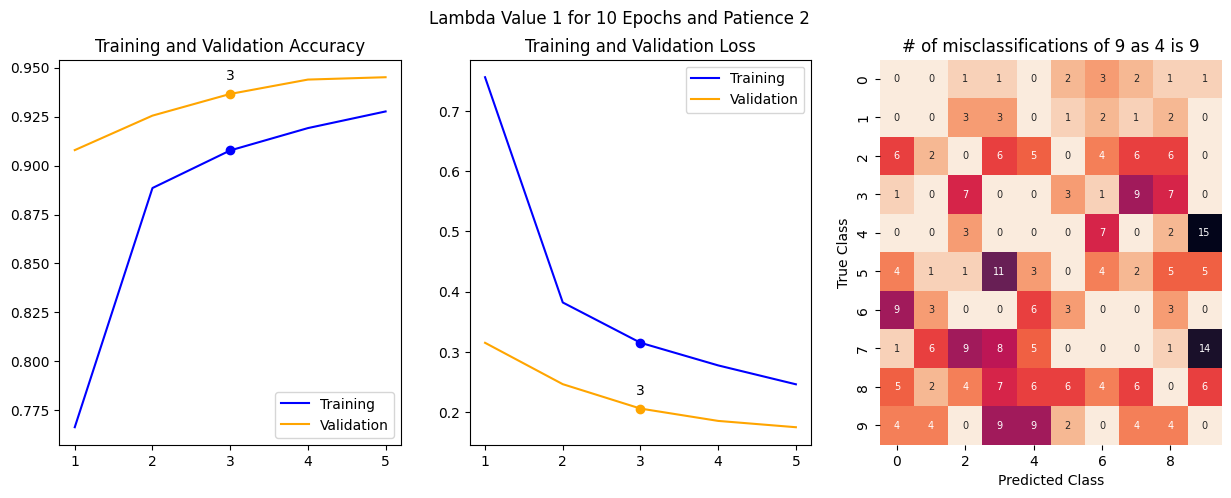

In [ ]:
plot_model_history(model_history, nb_epoch, cm3)
# plot_model_history(model2_history, nb_epoch, cm3)
# plt.gcf().set_size_inches(15, 5)  # this works 
plt.gcf().suptitle(f"Lambda Value {lambda_val} for {nb_epoch} Epochs and Patience {patience} " )
# print("The {0} runs {1} miles in {2} minutes".format("dog", 5, 10))

In [ ]:
# for i in (model_history_all):
#   plot_model_history(i, nb_epoch, cm3) # This doesn't work ecause its all on separate figures and
# it only takes a static number of epochs and cm


Text(0.5, 0.98, 'Misclassification Matrix for Validation Set with Lambda Value of 1-After 10 epochs and patience of 20')

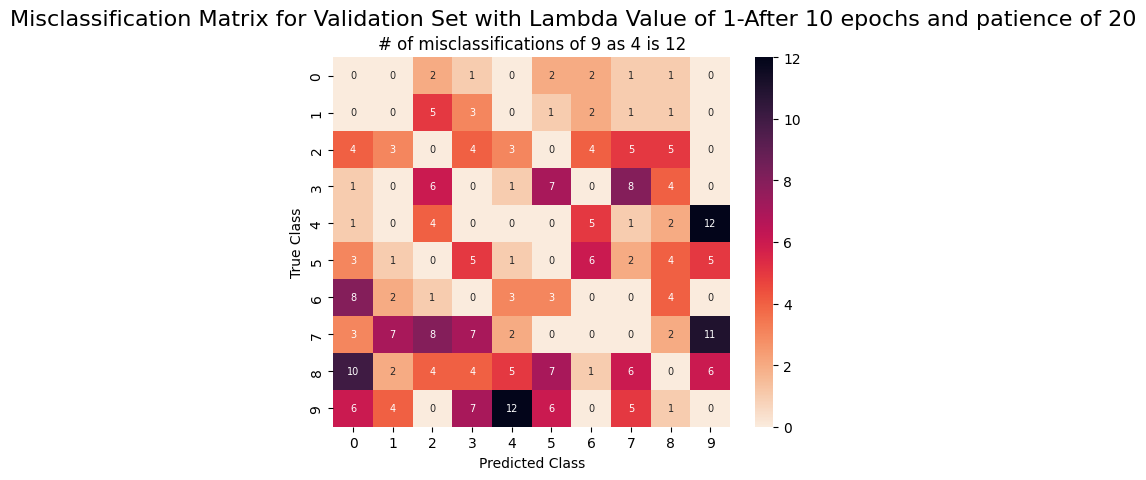

In [ ]:
cm3_wodiag = cm3*(np.ones((10,10)) - np.eye(10))

ax = sns.heatmap(cm3_wodiag, annot=True, annot_kws={"size": 7},  fmt='g', cmap=sns.cm.rocket_r) # font size
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
ax.set_title('# of misclassifications of 9 as 4 is '+str(cm3[4][9]))

fig = plt.gcf()
fig.suptitle('Misclassification Matrix for Validation Set with Lambda Value of '+str(lambda_val)+"-After "+str(nb_epoch)+" epochs and patience of "+str(patience), fontsize=16)

# cm3[4][9]


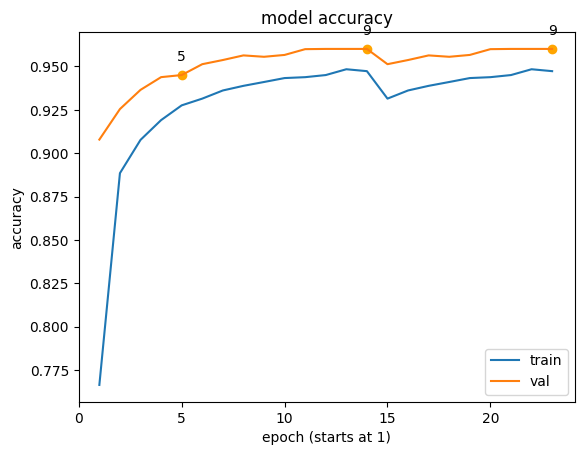

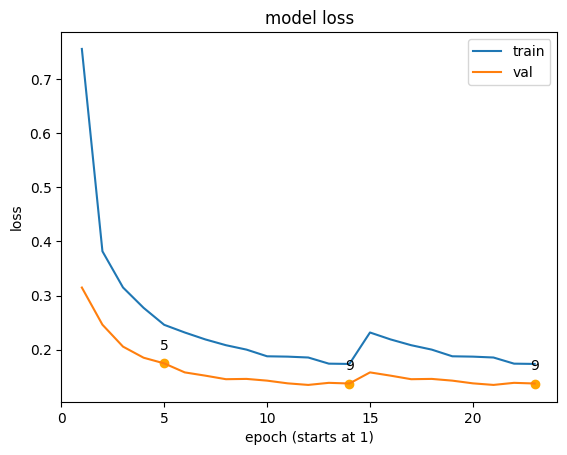

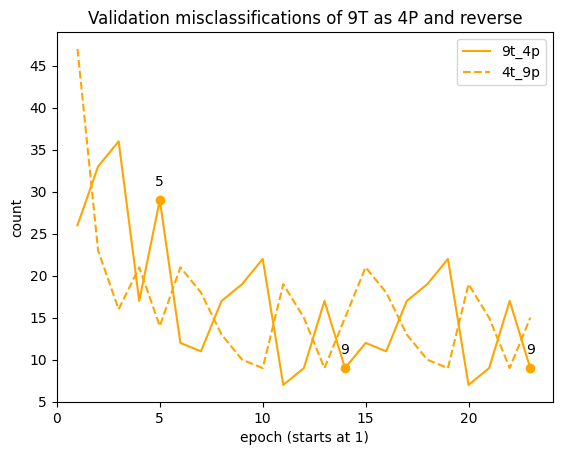

{'categorical_accuracy': array([0.76643336, 0.88851666, 0.9077    , 0.91909999, 0.92760003,
        0.93148333, 0.93618333, 0.93884999, 0.94106668, 0.94333333,
        0.94384998, 0.94506669, 0.94841665, 0.94731665, 0.93148333,
        0.93618333, 0.93884999, 0.94106668, 0.94333333, 0.94384998,
        0.94506669, 0.94841665, 0.94731665]),
 'val_categorical_accuracy': array([0.90786666, 0.92546666, 0.93653333, 0.94386667, 0.94506669,
        0.95133334, 0.95373333, 0.95639998, 0.95560002, 0.95666665,
        0.95999998, 0.96013331, 0.96013331, 0.96013331, 0.95133334,
        0.95373333, 0.95639998, 0.95560002, 0.95666665, 0.95999998,
        0.96013331, 0.96013331, 0.96013331]),
 'loss': array([0.75566751, 0.3818039 , 0.3149341 , 0.27733698, 0.24598627,
        0.23181352, 0.21899751, 0.20833229, 0.20017928, 0.18784767,
        0.18721178, 0.18560106, 0.17423497, 0.17371905, 0.23181352,
        0.21899751, 0.20833229, 0.20017928, 0.18784767, 0.18721178,
        0.18560106, 0.17423497, 

In [ ]:
plot_3_fx(model_history, model_history2, model_history2, 5, 9 , 9)
 

In [ ]:
def combine(*args): 
    combined_string = ""
    for arg in args:
        combined_string += str(arg)
    return combined_string

#example
combine("Hello", "World") #returns "HelloWorld"

'HelloWorld'

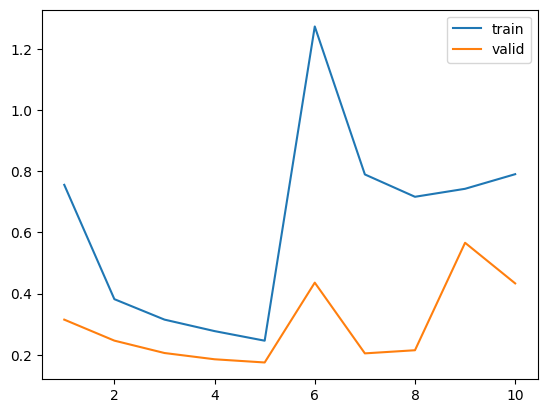

In [ ]:
plt.plot(range(1, len(model_history.history['loss'] + model2_history.history['loss'])+1),model_history.history['loss'] + model2_history.history['loss'], label='train')
plt.plot(range(1, len(model_history.history['val_loss'] + model2_history.history['val_loss'])+1),model_history.history['val_loss'] + model2_history.history['val_loss'] , label='valid')
plt.legend()

#### Plot all three phases together

In [ ]:
def plot_3_fx(model1_history, model2_history, model3_history, restored_weights1, restored_weights2, restored_weights3):
  
  tot_epochs = restored_weights1 + restored_weights2 + restored_weights3

  #Label is the epoch weights are restored 
  label1 = f"{restored_weights1}"
  #Label_vale is the value at which the epoch weights are restored 
  label_value1 = f"{ model1_history.history['val_categorical_accuracy'][restored_weights1-1]}"
  # print("Label1: ", label1, "Val_Cat_Acc Value1: ", label_value1)


  #Label is the epoch weights are restored in the second phase of training
  # if restoredweights are 5 then it'll be after the max number of epochs of the first models training 
  label2 = f"{restored_weights2}"
  #Label_vale is the value at which the epoch weights are restored 
  label_value2 = f"{ model2_history.history['val_categorical_accuracy'][restored_weights2-1]}"
  # print("Label2: ", label2, "Val_Cat_Acc Value2: ", label_value2)

  #Label is the epoch weights are restored in the second phase of training
  # if restoredweights are 5 then it'll be after the max number of epochs of the first models training 
  label3 = f"{restored_weights3}"
  #Label_vale is the value at which the epoch weights are restored 
  label_value3 = f"{ model3_history.history['val_categorical_accuracy'][restored_weights3-1]}"
  # print("Label3: ", label3, "Val_Cat_Acc Value3: ", label_value3)

 
  
  epochs = [restored_weights1, restored_weights2, restored_weights3]
  models = [model1_history, model2_history, model3_history]

  grab_n_epochs_of_model_metric_fun = lambda epoch, model, metric: model.history[metric][:epoch]

  model_total_cat_acc =     np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['categorical_accuracy']*3)), axis=0)
  model_total_val_cat_acc = np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['val_categorical_accuracy']*3)), axis=0)
  
  model_total_loss =        np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['loss']*3)), axis=0)
  model_total_val_loss =    np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['val_loss']*3)), axis=0)

  model_total_val_9T_4P =   np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['9T_4P']*3)), axis=0)
  model_total_val_4T_9P =   np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['4T_9P']*3)), axis=0)

  
  #ScatterPlotPoint and Annotate RestoredWeights1 
  offsets = [0,restored_weights1, restored_weights1+restored_weights2]
  labels = [label1, label2, label3]

  for metric in list(('val_categorical_accuracy', 'val_loss', '9T_4P')):


    if(metric=='val_categorical_accuracy'):
      plt.plot(range(1,tot_epochs+1), model_total_cat_acc)
      plt.plot(range(1,tot_epochs+1), model_total_val_cat_acc)
    elif(metric=='val_loss'):
      plt.plot(range(1,tot_epochs+1), model_total_loss)
      plt.plot(range(1,tot_epochs+1), model_total_val_loss)
    else:
      plt.plot(range(1,tot_epochs+1), model_total_val_9T_4P, color='orange')
      plt.plot(range(1,tot_epochs+1), model_total_val_4T_9P, color='orange', linestyle='dashed')

    plt.xlim(xmin=0)


    for epoch, model, offset, label in zip(epochs, models, offsets, labels):
      # print(f'Epoch of Restored-Weights: {epoch}, Model: {model}, Offset: {offset}')
      plt.scatter((epoch+offset), model.history[metric][epoch-1] , color='orange')
      plt.annotate(text=label,  xy=((epoch+offset), model.history[metric][epoch-1]),
                  textcoords="offset points", 
                  xytext=(0,10), 
                  ha='center')
    
    if(metric=='val_categorical_accuracy'):
      plt.ylabel('accuracy')
      plt.title('model accuracy')
      plt.legend(['train', 'val'], loc='lower right')
    

    elif(metric=='val_loss'):
      plt.ylabel('loss')
      plt.title('model loss')
      plt.legend(['train', 'val'], loc='upper right')

    else:
      plt.ylabel('count')
      plt.title('Validation misclassifications of 9T as 4P and reverse')
      plt.legend(['9t_4p', '4t_9p'], loc='upper right')
    

    plt.xlabel('epoch (starts at 1)') 
    
    plt.show()


  history =   {'categorical_accuracy': model_total_cat_acc , 
              'val_categorical_accuracy': model_total_val_cat_acc  , 
            'loss': model_total_loss,
              'val_loss': model_total_val_loss ,   
              '9T_4P': model_total_val_9T_4P ,  
              '4T_9P': model_total_val_4T_9P}
 


  return history
 


### *Keep Track of Experimental Admin Stuff - #Reps and #CostMatrix

> Change the cost matrix and number of reps and check the file extension name 


#### *Define Cost Matrix and Method

In [ ]:
# Experimental Admin Stuff

# # ### Weight of Misclassifications for three stages of training
# lambda1, lambda2, lambda3 = 1, 1, 1


# # ### Number of Epochs for each Stage of Training
# train_epochs1, train_epochs2, train_epochs3 = 5, 5, 20

# # ### Whether there is EarlyStopping and if so how many Epochs of Patience Patience=0 means no EarlyStopping
# es1, es2, es3 = 5, 5, 20

# # ### String of weights-of-misclassification for naming files
# ## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
# cost_str = str(lambda1) + "_" + str(lambda2) + "_"  + str(lambda3)
# epochs_str = str(train_epochs1) + "_" + str(train_epochs2) + "_"  + str(train_epochs3)
# patience_str = str(es1) + "_" + str(es2) + "_"  + str(es3)
# # ## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

 

# ### File Extension to reference in JMP : weights_method_costs1_2_3
# ## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# file_extension = "w[9,4]_L_" + cost_str + "_E_" + epochs_str + "_P_" + patience_str + "_"
# ## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# print(len(file_extension))


# np.set_printoptions(suppress=True)
# np.set_printoptions(precision=2)

# print("Last run using ", cost_str)
# print("File Extension ", file_extension)

#### Run Experiments

In [ ]:
#@title
# cm = np.zeros([10,10])
# combined_cms = np.empty((1,100))
count = 0
run = 0
rep = 0
total_reps = 2
 
admin_dictionary = {}
print("     | --- Init --- | | --- Mid --- | | --- Late --- | ")
for i in [1, 100, 1000]: #lambda1
  for j in [1, 100, 1000]:  #lambda2
    for k in   [1, 100, 1000]: #lambda3
      run+=1
      for rep in range(1,total_reps+1):
        count+=1
        lambda1 = i
        lambda2 =j
        lambda3 = k
        # ### Number of Epochs for each Stage of Training
        train_epochs1, train_epochs2, train_epochs3 = 5, 5, 25

        # ### Whether there is EarlyStopping and if so how many Epochs of Patience Patience=0 means no EarlyStopping
        es1, es2, es3 = 0, 0, 0

        # ### String of weights-of-misclassification for naming files
        ## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
        cost_str = str(lambda1) + "_" + str(lambda2) + "_"  + str(lambda3)
        epochs_str = str(train_epochs1) + "_" + str(train_epochs2) + "_"  + str(train_epochs3)
        patience_str = str(es1) + "_" + str(es2) + "_"  + str(es3)
        # ## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
        
        # ### Admin Dictionary to Save with Each File/Run
        admin_dictionary[run, rep] = {"count": count, "run": run, "rep":  rep, 
                            "lambda1":lambda1,
                            "lambda2":lambda2,
                            "lambda3":lambda3,
                            "epochs1": train_epochs1,
                            "epochs2": train_epochs2,
                            "epochs3": train_epochs3,
                            "es1":    es1,
                            "es2":    es2,
                            "es3":    es3,
                            "tf.keras.utils.set_random_seed": seed,
                            "OS environment python hash seed value": seed_value,

                            }




        

        ### File Extension to reference in JMP : weights_method_costs1_2_3
        ## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        file_extension = "w[9,4]_L_" + cost_str + "_E_" + epochs_str + "_P_" + patience_str + "_"
        ## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # print(len(file_extension))


        np.set_printoptions(suppress=True)
        np.set_printoptions(precision=2)

        # print("Last run using ", cost_str, "File Extension ", file_extension)
        print(f'{run} '*50)
        print(f"Count:{count}--Run:{run}--Rep:{rep}|Lambdas {i}, {j},{k} | Epochs: {train_epochs1} with {es1} , {train_epochs2} with {es2},  {train_epochs3} with {es3} | ")
        print(f'{run} '*50)

        combined_history_dictionary = {}  #because there will be a unknown number of epochs a dictionary is probly a better fit
        combined_cms       = {}



        def display_cm_after_training(training, cm):
          print("After ", str(training), " stage CM: \n", cm)
          print("CM[9,4]: ", cm[4][9]) #yes this is the right format dont change! [First Value is the Column][Second Value is the Row]
 

        # Initial Training _________________________________________________________
        cm1, history1, model1, restored_weights1 =  PA_method_epoch(None, lambda1, nb_epoch=train_epochs1, patience=es1 )    #Individual CM, and Training/Validation History
        # plot_fx(history1, restored_weights1)
        # display_cm_after_training("first", cm1)

        # Second Phase Training ______________________________________________________
        print("Run ", run, "Rep ", rep, "second-phase training with a  cost_matrix[9, 4] = ",  lambda2)
        cm2, history2, model2, restored_weights2 =  PA_method_epoch(model1, lambda2, nb_epoch=train_epochs2, patience=es2 )    #Individual CM, and Training/Validation History
        # plot_fx(history2, restored_weights2)
        # display_cm_after_training("second", cm2)

        
        # Third Phase Training ____________________________________________________________
        print("Run ", run, "Rep ",rep, "third-phase training with a  cost_matrix[9, 4] = ",  lambda3)
        cm3, history3, model3, restored_weights3 =  PA_method_epoch(model2, lambda3, nb_epoch=train_epochs3, patience=es3 )    #Individual CM, and Training/Validation History
        # plot_fx(history3, restored_weights3)
        # display_cm_after_training("third", cm3)
        


        # # Save the results of 1st 2nd and 3rd phase training in one combined_history_list or disctionary
        #   combined_history_dictionary[run, i] = {"First": history1, "Second": history2, "Third": history3}
        #   combined_history_list.extend((history1, history2, history3))
        cm1_array = np.asarray(cm1)  #Indiv CM as array for storing
        cm2_array = np.asarray(cm2)
        cm3_array = np.asarray(cm3)

        # This results in saving the three confusion matrices after the three stages of training
        # The shape of the combined Cms will be 1x300 so that all can be saved on one-row
      
        cms = np.vstack((cm1_array.reshape((1,100)),
                                  cm2_array.reshape((1,100)),
                                  cm3_array.reshape((1,100)))
                                )
        

        combined_history_4 = plot_3_fx(history1, history2, history3, restored_weights1, restored_weights2, restored_weights3)
        combined_history_dictionary[run, rep] = {"First": history1, "Second": history2, "Third": history3, 'Combined': combined_history_4, '3ConfusionMatrices': cms, 'admin': admin_dictionary[run,rep]}
        combined_cms[run, rep] = cms

        print("Run: ", run, " Rep: ", rep, "  complete \n")

        #Need to delete the model inside the history or else it won't pickle            
        # To access the dictionary history values for all three stages of training:
        for phase2 in ["First", "Second", "Third"]:
            # print(combined_history_dictionary[run,rep][i].history.keys())
            del combined_history_dictionary[run,rep][phase2].model #https://github.com/keras-team/keras/issues/646 from FChollet


        import pickle



        from datetime import date
        from datetime import datetime
        today = date.today()
        file_date = today.strftime("%Y_%m_%d")
        now = datetime.now() # current date and time
        file_time = now.strftime("%H%M")
        print("time:", file_time)
        str_reps = str(rep)
        str_runs = str(run)


        file_name =  "run" + str_runs + "_" + "rep_" + str_reps + "_" + file_extension + "_" + file_date + "_" + file_time +  "_.pkl"
        # print(file_name, " will be saved with ", combined_cms.shape)

        with open(path + file_name, 'wb') as handle:
              
            # A new file will be created
            pickle.dump(combined_history_dictionary, handle,  protocol=pickle.HIGHEST_PROTOCOL)
            print(file_name, " was saved to Google Drive ")

        #The following code only works if its saved in colab. I'm saving to MyDrive
        # from google.colab import files
        # files.download( file_name )  

        # print(file_name, " was saved to Downloads ")




# 

In [ ]:
# How many categories are there in the test set?

truth_num_per_category = Y_val.sum(axis=0)
print(truth_num_per_category)

Load Results

I have a lot of pickle files.  Let's see if I can load them all up and put in a csv format.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/Con3"

path = "/content/drive/MyDrive/Con3/"

file_name = "delete_later.pkl"

import pickle 

import os

dir = path

dict_of_run_files = {}

count = 0
for file in os.listdir(path):
  if file.endswith(".pkl") and file.startswith("run"):
    # myfunction(file)
    with open(path + file, 'rb') as handle:
    # Call load method to deserialze
      dict_of_run_files[file] = pickle.load(handle)
      # list_of_files.extend(value for name, value in sorted(os.listdir(path)).items(), key=lambda item: item[0]) if name.startswith('run')
      count+=1 
      # print(unpickled_object == variable_to_be_deleted)
      print(count, ". ", file, " was saved to dict_of_run_files. ")

      

How to get into the "dict_of_run_files" variable and dig out each of the contents we need in each pickle file.

We need at least the following information in a dataframe:

UniqueID | Date_Time |  Run | Rep | Lambda = (i,j,k) | Epochs = (E1, E2, E3) | EarlyStop Patience = (P1, P2, P3) | Train/Val Accuracy | # of Misclassifications of [9t, 4p] | # Reverse Misclassifications | Final CM | Seed1 | Seed2 
-- | -- | --| --| --| --| --| --| -- | --| --| --| --
int | string | int | int | tuple | tuple | tuple | float | int | int | (1,100) (1,100), (1,100) | int | int





In [ ]:
column_name_list = ["UniqueID" , "Date_Time" ,  "Run" , "Rep" , "Lambda = (i,j,k)" , "Epochs = (E1, E2, E3)" , "EarlyStop Patience = (P1, P2, P3)" , "Val Accuracy" , "# of Misclassifications of [9t, 4p]" , "# Reverse Misclassifications" ,"Final CM", "Seed1" , "Seed2" ]


Unique ID can come later from just the order of the index or the key-name-of the file since each one has a unique last file_name.

Date_Time can come from the last part of the file name string, although in hind sight would have been nice to save to the admin key

Run really can't be a trusted Run Number anymore since I had some trouble with it, but can be cleaned up based off the lambda-epochs-patience values.

Rep is Rep specified in the Dictionary.



In [ ]:
# dict_of_run_files.keys()
# An example of a key is 'run1_rep_1_w[9,4]_L_1_1_1_E_5_5_25_P_0_0_25__2023_03_09_1329_.pkl'

#I later had the great idea of adding an admin file so some files have it some don't.
#This one doesn't.
try:
  dict_of_run_files['run1_rep_1_w[9,4]_L_1_1_1_E_5_5_25_P_0_0_25__2023_03_09_1329_.pkl'][(1,1)]['admin']
  

print("Run:" , dict_of_run_files['run23_rep_1_w[9,4]_L_100_1_100_E_5_5_25_P_0_0_0__2023_03_09_1434_.pkl'][(23,1)]['admin']['run'])
print("Rep:" , dict_of_run_files['run23_rep_1_w[9,4]_L_100_1_100_E_5_5_25_P_0_0_0__2023_03_09_1434_.pkl'][(23,1)]['admin']['rep'])



In [ ]:
dict(list_of_files[0]).values()

In [ ]:
#Save a file to myDrive/con3

# Analyze 

\\


In [ ]:
# import numpy as np
# import pandas as pd
# empty_cm = np.zeros((10,10))  
# empty_cm=pd.DataFrame(empty_cm)

# empty_cm.columns = ['0p', '1p', '2p', '3p', '4p', '5p', '6p', '7p', '8p', '9p']
# empty_cm.index = ['0t', '1t', '2t', '3t', '4t', '5t', '6t', '7t', '8t', '9t']

# # print(myvar_cm_average)

# empty_cm_array = np.asarray(empty_cm)
# empty_cm_array_1_100 = np.reshape(empty_cm_array,(1,100))
# # print(cm_average_array)

# df = empty_cm
# df_new = pd.DataFrame(empty_cm_array_1_100,  columns=pd.MultiIndex.from_product([ df.index,df.columns]))
# df_new.columns.to_flat_index()
# df_new.columns   = ['_'.join(col) for col in df_new.columns.values]

# # Now convert combined_cms of size 30x100 to a panda dataframe
# cms_df = pd.DataFrame(combined_cms, columns=[df_new.columns], index=["First", "Second", "Third"])

# cms_df

# for run in runs:
#   for rep in reps:
#     for phase in phases:
#       pd.DataFrame(combined_history_dictionary[run,rep]["3ConfusionMatrices"], columns=[df_new.columns], index=["First", "Second", "Third"])

In [ ]:
# combined_cms[0,]

In [ ]:
# combined_cms_df["9t_4p"]

In [ ]:
# np.average(combined_cms_df["9t_4p"])

In [ ]:
# csv_filename = file_name[:-4] + ".csv"

# combined_cms_df.to_csv(csv_filename)
# # 

# from google.colab import files
# files.download(csv_filename )

# print("Downloading ", csv_filename , " of shape ", combined_cms_df.shape)

In [ ]:
# df = pd.DataFrame(sum(var)/len(var), columns=["Values"]) 
# # print(df)

# df.style.format({
#   'Values': lambda val: f'{val:,.2f}',
# })

# (df.sort_values(by="Values", ascending=False)[0:20])


# df_sorted = df.sort_values(by="Values", ascending=False)[10:]  #the top 10 are usually diagonal


# df_sorted.style.format({
#   'Values': lambda val: f'{val:,.2f}',
# })

# import math

# print("On average...")
# print("Num 1 misclassifications are misclassifying a ", math.floor((df_sorted["Values"].index[0])/10), " as a ", df_sorted["Values"].index[0]%10, "  (", (df_sorted["Values"].values[0]), " times)" )
# print("Num 2 misclassifications are misclassifying a ", math.floor((df_sorted["Values"].index[1])/10), " as a ", df_sorted["Values"].index[1]%10, "  (", (df_sorted["Values"].values[1]), " times)" )
# print("Num 3 misclassifications are misclassifying a ", math.floor((df_sorted["Values"].index[2])/10), " as a ", df_sorted["Values"].index[2]%10, "  (", (df_sorted["Values"].values[2]), " times)" )




In [ ]:
# df_percents = pd.DataFrame( ((sum(var)*100/len(var)).reshape((10,10))/truth_num_per_category).reshape((100)), columns = ["Values"])


# df_sorted_percents = df_percents.sort_values(by="Values", ascending=False)[10:]  #the top 10 are usually diagonal

# df_sorted_percents.style.format({
#   'Values': lambda val: f'{val:,.2f}',
# })

# print("On average .. ")
# print("Num 1 percent misclassifications", math.floor((df_sorted_percents["Values"].index[0])/10), " as ", df_sorted_percents["Values"].index[0]%10, (df_sorted_percents["Values"].values[0]), " percent" )
# print("Num 2 percent misclassifications", math.floor((df_sorted_percents["Values"].index[1])/10), " as ", df_sorted_percents["Values"].index[1]%10,  (df_sorted_percents["Values"].values[1]), " percent" )
# print("Num 3 percent misclassifications", math.floor((df_sorted_percents["Values"].index[2])/10), " as ", df_sorted_percents["Values"].index[2]%10, (df_sorted_percents["Values"].values[2]), " percent" )






# Extraneous

#### To reference later: 

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb#scrollTo=UJ589fn8ST3x

To train a model with class weights:

```
class_weight = {0: weight_for_0, 1: weight_for_1}

weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),

    # The class weights go here
    class_weight=class_weight)
```



##### extra

In [ ]:
# Extraneous information I am not using at the moment

# model.compile(
#      optimizer='adam',
#      loss=WeightedCategoricalCrossentropy(cost_matrix)
#      )

## Model Saving

# model.save(save_version_dir,save_format='tf')

## Model Loading

# model = tf.keras.models.load_model(
#     save_version_dir,
#     compile=True,
#     custom_objects={
#         'WeightedCategoricalCrossentropy': WeightedCategoricalCrossentropy(cost_matrix)
#         }
#     )
 

#### Experimental Runs 

starting to think about how i would shape the initial, middle and late training experiments.  

In [ ]:
count = 0
run = 0
rep = 0

print("     | --- Init --- | | --- Mid --- | | --- Late --- | ")
for i in ["   1"," 100", "1000"]: #lambda1
  
  for j in  ["   1"," 100", "1000"]:  #lambda2
    for k in   ["   1"," 100", "1000"]: #lambda3
      run+=1
      for rep in range(1,2+1):
        count+=1
        print(f"{count}--{run}--{rep}    |     {i}     ,     {j}    ,    {k}     | ")
        



Run:47--Rep:1|Lambdas 1000, 100,100 | Epochs: 5 with 0 , 5 with 0,  25 with 0